# Sales Prediction for Time Series Data

This notebook will prepare separate datasets based on different scaling methods.  The data will also be divided into training, validation, and test set using a validation plan that is suitable for time series data.  The plan will make sure that there will be no data leakage, such that the models will not train on future information. 

## Part 3: Feature Scaling 

#### Step 1: Scale data
Different scaling methods of numeric features will be performed:  Standard Scaler, Min-Max Scaler, Robust Scaler, and Quantile Scaler.  The test set will fit on the training set.

####  Step 2: Validation and Ensembling Plan
<br>The date_block_num in the dataset ranges from 12 (Jan 2014) to 34 (Nov 2015).

* Level I: three **base models** will be utilized (Linear Regression, Light GBM, Neural Network)
<br>Level 1 base model will be trained using date_block_num 12 to 31 <br>Level 1 base model will be validated using date_block_num 32 <br>

* Level II: Ensembling and Stacking
<br>The level 2 **meta models** will be trained using the prediction from Level 1 models for date_block_num 32 
<br>Same base model trained using date_block_num 12 to 31 will be used to get prediction for date_block_num 33. This will be input to validate the level 2 meta models.
* The final submission will be trained using parameters from Level I for date_block_num 1-33.  The prediction will be for date_block_number 34, which will be ensembled using the parameters from level II.  

In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.externals import joblib
import random
import numpy as np
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

def sort_columns(df):
    '''
        sort columns starting by date, shop_id, then item_id
    '''
    colA = ['date_block_num', 'shop_id', 'item_id']
    colB = list(df.columns.difference(colA))
    df = df[colA + sorted(colB)]
    return df

def scale_fit(X_train, X_test, scaler, tree = None):
    '''
        scale and transform dataframes
    '''
    # separate dataset into numeric and categoricals
    if tree == None:
        scaleCols = X_train.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns
    elif tree == True:
    # this set of columns will not scale features that are related to ranking, percentage or standard deviation
        priceCols = [col for col in X_train.columns if 'price' in col]
        revenueCols = [col for col in X_train.columns if 'revenue' in col]
        rankCols = [col for col in X_train.columns if 'rank' in col]
        pctCols = [col for col in X_train.columns if 'pct' in col]
        stdCols = [col for col in X_train.columns if 'std' in col]
        scaleCols = list(set(priceCols + revenueCols) - set(rankCols + pctCols + stdCols))
    
    #print('Scaling these columns:', scaleCols)
    otherCols = X_train.columns[~X_train.columns.isin(scaleCols)]
    X_train_numeric =  X_train[scaleCols]
    X_train_cat = X_train[otherCols]
    X_test_numeric = X_test[scaleCols]
    X_test_cat = X_test[otherCols]
    
    # fit scaler to training set and apply to test
    scaler = scaler
    print('Using this scaler:', scaler)
    scaler.fit(X_train_numeric)
    X_train_numeric = scaler.transform(X_train_numeric)# converts to float64 array 
    X_test_numeric = scaler.transform(X_test_numeric)
    
    # merge scaled data back to the rest of the data
    X_train_numeric = pd.DataFrame(data = X_train_numeric, columns = scaleCols)
    X_test_numeric = pd.DataFrame(data = X_test_numeric, columns = scaleCols)
    
    X_train_cat = X_train_cat.reset_index(drop=True)
    X_test_cat = X_test_cat.reset_index(drop=True)
    
    X_train = pd.concat([X_train_cat, X_train_numeric], axis=1)
    X_test = pd.concat([X_test_cat, X_test_numeric], axis=1)
    
    # downcast to 32 from 64
    X_train = downcast_dtypes(X_train)
    X_test = downcast_dtypes(X_test)
    
    # sort columns
    X_train = sort_columns(X_train)
    X_test =  sort_columns(X_test)
    
    return X_train, X_test


In [3]:
DATA_FOLDER = '../data'
submission = pd.read_csv(os.path.join(DATA_FOLDER, 'sample_submission.csv.gz'))
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))
all_data = pd.read_pickle(DATA_FOLDER + '/all_data_unscaled_clipped')
test = downcast_dtypes(test)

Create datasets that will be used in modeling.  

In [4]:
to_drop_cols = list(all_data.select_dtypes(include = ['object']).columns) + ['target_item_cnt']
to_drop_cols

['item_category_name',
 'item_name',
 'set',
 'shop_name',
 'yymm',
 'target_item_cnt']

Get the full training and testing set for use in final submission

In [5]:
last_block = 34
X_train_full = all_data.loc[(all_data['date_block_num'] < last_block)].drop(to_drop_cols, axis=1)
y_train_full = all_data.loc[(all_data['date_block_num'] < last_block), 'target_item_cnt'].values
X_train_full = sort_columns(X_train_full)

In [6]:
#X_test_full = all_data.loc[(all_data['date_block_num'] == last_block)].drop(to_drop_cols, axis=1)
X_test_full = all_data.loc[(all_data['date_block_num'] == last_block)]
X_test_full = pd.merge(X_test_full, test, how='left', on=['shop_id','item_id'])
X_test_full = X_test_full.sort_values(['ID'])
X_test_full = X_test_full.reset_index(drop = True)
ID = X_test_full['ID']
X_test_full = X_test_full.drop(to_drop_cols+['ID'], axis = 1)
X_test_full = sort_columns(X_test_full)

Get the index of the samples.
<br> Only 20% of the items that appeared before block 32 will be used for model tuning and validation.  

In [7]:
last_block = 32
sampleSize = 0.2
random.seed(a = 123)
sample= list(all_data.item_id.unique())
sample= list(np.random.choice(sample, size= int(len(sample)*sampleSize), replace=False, p=None))

X_train_lev_1_index = X_train_full.loc[(X_train_full['date_block_num'] <  last_block) & (X_train_full['item_id'].isin(sample))].index
X_val_lev_1_index = X_train_full.loc[(X_train_full['date_block_num'] == last_block) & (X_train_full['item_id'].isin(sample))].index
X_val_lev_2_index = X_train_full.loc[(X_train_full['date_block_num'] == last_block+1) & (X_train_full['item_id'].isin(sample))].index

y_train_lev_1 = y_train_full[X_train_lev_1_index]
y_val_lev_1 =  y_train_full[X_val_lev_1_index]
y_val_lev_2 = y_train_full[X_val_lev_2_index]

In [13]:
DATA_FOLDER = '../data/'

In [12]:
X_train_full.to_pickle(DATA_FOLDER + 'X_train_full_noScale')
X_test_full.to_pickle(DATA_FOLDER + 'X_test_full_noScale')

In [14]:
joblib.dump(y_train_lev_1, DATA_FOLDER + "y_train_lev_1.pkl")
joblib.dump(y_val_lev_1, DATA_FOLDER + "y_val_lev_1.pkl")
joblib.dump(y_val_lev_2, DATA_FOLDER + 'y_val_lev_2.pkl')
joblib.dump(y_train_full, DATA_FOLDER + 'y_train_full.pkl')
joblib.dump(ID, 'ID.pkl')

['ID.pkl']

### Feature Scaling

#### No scaling

In [15]:
X_train_lev_1_noScaler = X_train_full.iloc[X_train_lev_1_index]
X_val_lev_1_noScaler = X_train_full.iloc[X_val_lev_1_index ]
X_val_lev_2_noScaler = X_train_full.iloc[X_val_lev_2_index ]
X_train_lev_1_noScaler.to_pickle(DATA_FOLDER + 'X_train_lev_1_noScaler')
X_val_lev_1_noScaler.to_pickle(DATA_FOLDER + 'X_test_lev_1_noScaler')
X_val_lev_2_noScaler.to_pickle(DATA_FOLDER + 'X_test_lev_2_noScaler')

#### Standard Scaler
Standardize features by removing the mean and scaling to unit variance

In [20]:
scaler = preprocessing.StandardScaler()

In [21]:
X_train_standardScaler, X_test_standardScaler =  scale_fit(X_train_full, X_test_full, scaler)

Using this scaler: StandardScaler(copy=True, with_mean=True, with_std=True)


In [22]:
X_train_standardScaler.to_pickle(DATA_FOLDER + 'X_train_standardScaler')
X_test_standardScaler.to_pickle(DATA_FOLDER + 'X_test_standardScaler')

In [23]:
X_train_lev_1_standardScaler = X_train_standardScaler.iloc[X_train_lev_1_index]
X_val_lev_1_standardScaler = X_train_standardScaler.iloc[X_val_lev_1_index]
X_val_lev_2_standardScaler = X_train_standardScaler.iloc[X_val_lev_2_index]

In [24]:
X_train_lev_1_standardScaler.to_pickle(DATA_FOLDER + 'X_train_lev_1_standardScaler')
X_val_lev_1_standardScaler.to_pickle(DATA_FOLDER + 'X_test_lev_1_standardScaler')
X_val_lev_2_standardScaler.to_pickle(DATA_FOLDER + 'X_test_lev_2_standardScaler')

#### Robust Scaler
The centering and scaling statistics of this scaler are based on percentiles and are therefore not influenced by a few number of very large marginal outliers

In [25]:
scaler = preprocessing.RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0), copy=True)

In [26]:
X_train_RobustScaler, X_test_RobustScaler =  scale_fit(X_train_full, X_test_full, scaler)

Using this scaler: RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)


In [27]:
X_train_RobustScaler.to_pickle(DATA_FOLDER +'X_train_RobustScaler')
X_test_RobustScaler.to_pickle(DATA_FOLDER +'X_test_RobustScaler')

In [28]:
X_train_lev_1_RobustScaler = X_train_RobustScaler.iloc[X_train_lev_1_index]
X_val_lev_1_RobustScaler = X_train_RobustScaler.iloc[X_val_lev_1_index]
X_val_lev_2_RobustScaler = X_train_RobustScaler.iloc[X_val_lev_2_index]

In [29]:
X_train_lev_1_RobustScaler.to_pickle(DATA_FOLDER +'X_train_lev_1_RobustScaler')
X_val_lev_1_RobustScaler.to_pickle(DATA_FOLDER +'X_test_lev_1_RobustScaler')
X_val_lev_2_RobustScaler.to_pickle(DATA_FOLDER +'X_test_lev_2_RobustScaler')

#### MinMax Scaler
Rescales the data set such that all feature values are in the range [0, 1].  As StandardScaler, MinMaxScaler is very sensitive to the presence of outliers

In [30]:
scaler = preprocessing.MinMaxScaler()

In [31]:
X_train_MinMaxScaler, X_test_MinMaxScaler =  scale_fit(X_train_full, X_test_full, scaler)

Using this scaler: MinMaxScaler(copy=True, feature_range=(0, 1))


In [32]:
X_train_MinMaxScaler.to_pickle(DATA_FOLDER +'X_train_MinMaxScaler')
X_test_MinMaxScaler.to_pickle(DATA_FOLDER +'X_test_MinMaxScaler')

In [33]:
X_train_lev_1_MinMaxScaler = X_train_MinMaxScaler.iloc[X_train_lev_1_index]
X_val_lev_1_MinMaxScaler = X_train_MinMaxScaler.iloc[X_val_lev_1_index]
X_val_lev_2_MinMaxScaler = X_train_MinMaxScaler.iloc[X_val_lev_2_index]

In [34]:
X_train_lev_1_MinMaxScaler.to_pickle(DATA_FOLDER +'X_train_lev_1_MinMaxScaler')
X_val_lev_1_MinMaxScaler.to_pickle(DATA_FOLDER +'X_test_lev_1_MinMaxScaler')
X_val_lev_2_MinMaxScaler.to_pickle(DATA_FOLDER +'X_test_lev_2_MinMaxScaler')

#### QuantileTransformer
transforms the features to follow a uniform or a normal distribution. Therefore, for a given feature, this transformation tends to spread out the most frequent values.

In [35]:
scaler = preprocessing.QuantileTransformer(n_quantiles=100)

In [36]:
X_train_QuantileScaler, X_test_QuantileScaler =  scale_fit(X_train_full, X_test_full, scaler)

Using this scaler: QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=100,
          output_distribution='uniform', random_state=None,
          subsample=100000)


In [37]:
X_train_QuantileScaler.to_pickle(DATA_FOLDER +'X_train_QuantileScaler')
X_test_QuantileScaler.to_pickle(DATA_FOLDER +'X_test_QuantileScaler')

In [38]:
X_train_lev_1_QuantileScaler = X_train_QuantileScaler.iloc[X_train_lev_1_index]
X_val_lev_1_QuantileScaler = X_train_QuantileScaler.iloc[X_val_lev_1_index]
X_val_lev_2_QuantileScaler = X_train_QuantileScaler.iloc[X_val_lev_2_index]

In [39]:
X_train_lev_1_QuantileScaler.to_pickle(DATA_FOLDER +'X_train_lev_1_QuantileScaler')
X_val_lev_1_QuantileScaler.to_pickle(DATA_FOLDER +'X_test_lev_1_QuantileScaler')
X_val_lev_2_QuantileScaler.to_pickle(DATA_FOLDER +'X_test_lev_2_QuantileScaler')

#### *Scaling for tree methods*

In [40]:
scaler = preprocessing.RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0), copy=True)

In [41]:
X_train_RobustScalerTree, X_test_RobustScalerTree =  scale_fit(X_train_full, X_test_full, scaler, tree = True)

Using this scaler: RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)


In [42]:
X_train_RobustScalerTree.to_pickle(DATA_FOLDER +'X_train_RobustScalerTree')
X_test_RobustScalerTree.to_pickle(DATA_FOLDER +'X_test_RobustScalerTree')

In [43]:
X_train_lev_1_RobustScalerTree = X_train_RobustScalerTree.iloc[X_train_lev_1_index]
X_val_lev_1_RobustScalerTree = X_train_RobustScalerTree.iloc[X_val_lev_1_index]
X_val_lev_2_RobustScalerTree = X_train_RobustScalerTree.iloc[X_val_lev_2_index]

In [44]:
X_train_lev_1_RobustScalerTree.to_pickle(DATA_FOLDER +'X_train_lev_1_RobustScalerTree')
X_val_lev_1_RobustScalerTree.to_pickle(DATA_FOLDER +'X_test_lev_1_RobustScalerTree')
X_val_lev_2_RobustScalerTree.to_pickle(DATA_FOLDER +'X_test_lev_2_RobustScalerTree')

### Visualize the effect of scaling

In [45]:
def plot_scaler(df):
    plt.rcParams['figure.figsize'] = (18, 4)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4)
    sns.distplot(df.price_weighted_diff_lag_1, ax=ax1)
    sns.distplot(df.price_weighted_lag_1, ax=ax2)
    sns.distplot(df.rank_cat_revenue_lag_1, ax=ax3)
    sns.distplot(df.target_item_cnt_mean_3m, ax=ax4)

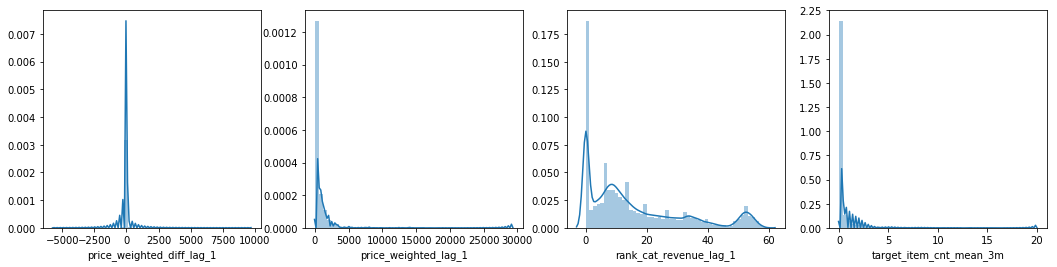

In [46]:
plot_scaler(X_train_lev_1_noScaler) 

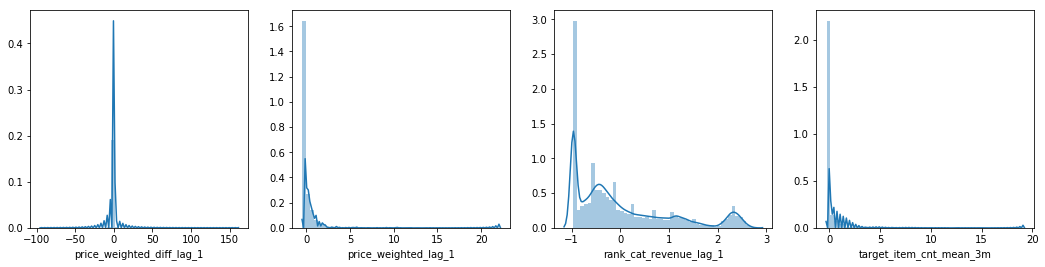

In [47]:
plot_scaler(X_train_lev_1_standardScaler)

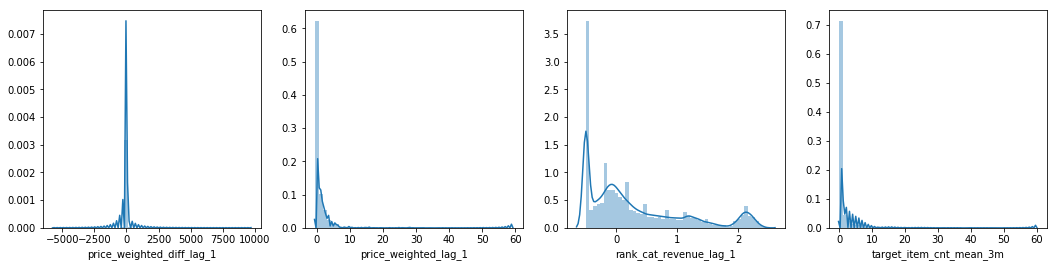

In [48]:
plot_scaler(X_train_lev_1_RobustScaler)

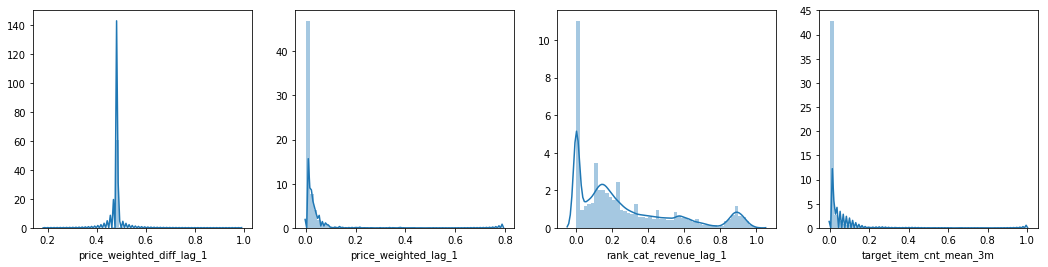

In [49]:
plot_scaler(X_train_lev_1_MinMaxScaler)

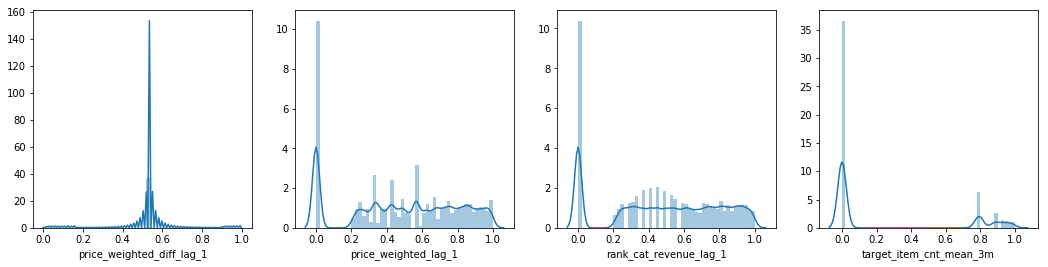

In [50]:
plot_scaler(X_train_lev_1_QuantileScaler)